<a href="https://colab.research.google.com/github/AbeTetsuyaR/AbePPO/blob/main/AbePPO0807.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import time
import cProfile
import sys
import copy
from torch.distributions.categorical import Categorical
import math
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from tqdm import tqdm  # tqdmをインポート
import matplotlib.pyplot as plt

from scipy.stats import gamma, uniform
import math

In [2]:
class Environment:
    def __init__(self, n_units=2):
        self.n_units = n_units #number of unit
        self.n_states = 5 #number of state
        self.inventory = 0
        self.demand = 0
        self.maintenance_status = [0] * self.n_units
        self.interval = 24
        self.remain_interval = 24
        self.MAX_speed = 10/self.interval
        self.MAX_inventory = 0
        self.MAX_demand = 15
        self.MAX_maintenance_time = 0

        self.load_total=1

        self.cp = 500#
        self.cc = 1800#

        self.cps = 0
        self.co = 5
        self.cs = 500#

        self.levels = [0] * self.n_units
        self.shape = 3
        self.penalty = 1
        self.L = 100#
        self.P_Cost =[[100,120,140,160,2500],
                      [120,140,160,180,2520],
                      [140,160,180,200,2540],
                      [160,180,200,220,2560],
                      [2500,2520,2540,2560,2580]]#一旦

        self.failure_keep1 = 0 #1つ故障しているのに保全を選択しなかった回数
        self.failure_keep2 = 0 #2つ故障しているのに保全を選択しなかった回数
        self.failure_keep3 = 0 #3つ故障しているのに保全を選択しなかった回数
        self.replace_chance = 0 #保全を選択できた回数

    def init_random(self):
        l = range(self.n_states)
        m = range(self.MAX_maintenance_time)
        flag = True
        while flag:
            for unit_idx in range(self.n_units):
                self.levels[unit_idx] = random.choice(l)
                if self.levels[unit_idx] == self.n_states-1:
                        flag = False
                #if self.levels[unit_idx] == 0:
                    #self.maintenance_status[unit_idx] = random.choice(m)

        #需要
        mean = 10
        variance = 2  # 標準偏差
        mu = np.log(mean**2 / np.sqrt(variance**2 + mean**2))
        sigma = np.sqrt(np.log(1 + (variance**2 / mean**2)))
        self.demand = np.random.lognormal(mu, sigma)
        if self.demand > 15:
            self.demand = 15
        self.demand = random.uniform(0,15)
        #意思決定時
        #self.remain_interval = random.uniform(0, self.interval)
        #在庫
        self.inventory = random.uniform(0,self.MAX_inventory)

        level_ohe, mstatus_ohe = self.one_hot_encode()

        return level_ohe, mstatus_ohe, \
               0, self.demand * 2 /15 - 1, self.remain_interval * 2 / self.interval - 1



    def reset(self):
        self.levels = np.zeros(self.n_units)

    def complete_maintenance(self, unit_idx):
        self.levels[unit_idx] = 0

    def get_ability(self, level): #良品率
        if level == 0:
            return 1
        elif level == 1:
            return 0.8
        elif level ==2:
            return 0.5
        elif level == 3:
            return 0.1
        return (self.n_states - 1 - level) / (self.n_states - 1)

    def update_demand(self, speed, ability, time):
        if self.demand >= self.inventory:
            self.demand -= self.inventory
            self.inventory = 0.0
        else:
            self.inventory -= self.demand
            self.demand = 0.0
        return max(0, self.demand-self.inventory-ability*speed*time)

    def update_inventory(self, speed, ability, time):
        if self.demand <= self.inventory + ability * speed * time:
            return min(self.MAX_inventory, -self.demand+self.inventory+ability*speed*time), max(0, -self.MAX_inventory-self.demand+self.inventory+ability*speed*time)
        else:
            return 0.0, 0.0

    def get_maintenance_time(self,level):
        return 0

    def update_maintenance_time(self, unit_idx):
        return 0

    def one_hot_encode(self):
        level_ohe = []
        mstatus_ohe = []
        for unit_idx in range(self.n_units):
            l = [0] * self.n_states
            m = [0] * (self.MAX_maintenance_time + 1)
            l[min(math.floor(self.levels[unit_idx]),self.n_states-1)] = 1
            m[self.maintenance_status[unit_idx]] = 1
            level_ohe = level_ohe + l
            mstatus_ohe = mstatus_ohe + m
        return level_ohe, mstatus_ohe



    def operation(self, replacements, speeds):
        reward = 0

        #生産速度の調整
        for i in range(self.n_units):
            if speeds[i] < 0:
                #reward -= self.penalty
                speeds[i] = 0
            if speeds[i] > 1:
                speeds[i] = 1
                #reward -= self.penalty
            #if speeds[i] < 0.01:
                #speeds[i] = 0

        flag = 0

        #保全の意思決定

        if replacements==[1,1]: #稼働継続
          # パラメータの設定
          scales=[0,0]
          shape1 = 0.69  # ガンマ分布のパラメータ v1 用
          shape2 = 0.69  # ガンマ分布のパラメータ v2 用
          tau = 0.5  # ケンドールの順位相関係数

          theta = 1 / (1 - tau)
          # 一様乱数を生成
          u = uniform.rvs(size=1)
          v = uniform.rvs(size=1)

          # ガンベルコピュラの変換適用
          #c = (-np.log(u)) ** theta + (-np.log(v)) ** theta
          #u_transformed = np.exp(-c**(1/theta))
          #v_transformed = np.exp(-c**(1/theta))

          # 一様乱数をガンマ分布の逆関数に通す

          #load_totalを考慮した調整
          if speeds[0]>self.load_total:
            speeds[0]=self.load_total
          speeds[1]=self.load_total-speeds[0]
          if speeds[1]>self.load_total:
            speeds[1]=1
            speeds[0]=self.load_total-speeds[1]
          #print(speeds, "speeds")
          #尺度パラメータ計算
          for i in range(self.n_units):
            scales[i]=6.491*(speeds[i]**2)+0.726


          v1 = gamma.ppf(u, shape1, scale=scales[0])
          v2 = gamma.ppf(v, shape2, scale=scales[1])

          #print("稼働継続")
          #print(v1,v2, "劣化増分")
          self.levels[0]+=v1/25##
          self.levels[1]+=v2/25##
          #print(self.levels, "劣化")

          reward -= self.P_Cost[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)]

        elif replacements==[0,1]: #1のみ取替
          self.levels[0]=0
          reward -= self.cs
          if self.levels[0]<self.n_states-1:
            reward -= self.cp
          else:
            reward -= self.cc

        elif replacements==[1,0]: #2のみ取替
          self.levels[1]=0
          reward -= self.cs
          if self.levels[1]<self.n_states-1:
            reward -= self.cp
          else:
            reward -= self.cc

        else: #両方取替
          self.levels=[0,0]
          reward -= self.cs
          if self.levels[0]<self.n_states-1:
            reward -= self.cp
          else:
            reward -= self.cc
          if self.levels[1]<self.n_states-1:
            reward -= self.cp
          else:
            reward -= self.cc


        #print(self.levels)
        #print(reward)




        level_ohe, mstatus_ohe = self.one_hot_encode()

        #print(f'状態:{self.levels}, 保全状態:{self.maintenance_status}, 在庫:{self.inventory}, 需要:{self.demand}, 残り時間:{self.remain_interval}, 保全行動:{replacements}, {speeds}')
        #print("#############")

        flag = 0

        return reward, level_ohe, mstatus_ohe, \
               0, self.demand * 2 /15 - 1, 0, flag
        #return reward, level_ohe, mstatus_ohe, \
        #       0, (self.demand-mean)/variance, self.remain_interval * 2 / self.interval - 1, flag


    #劣化レベル順にすべき可能性

In [3]:
class PPOMemory:
    def __init__(self,batch_size, interval, beta, GAE_lam):
        self.states = []
        self.probs = []
        self.vals = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.time = []
        self.batch_size = batch_size
        self.interval = interval
        self.beta = beta
        self.advantage = []
        self.lam = GAE_lam

    def generate_advantage(self):

        """
        advantage = np.zeros(len(self.rewards),dtype=np.float32)
        for t in range(len(self.rewards)-1):
            a_t = 0
            for k in range(t, len(self.rewards)-1):
                a_t += math.exp(-self.beta * self.time[k]) * \
                    (self.rewards[k]+math.exp(-self.beta * (-self.time[k]%self.interval+self.interval))*self.vals[k+1]-self.vals[k])
            advantage[t] = a_t
        self.advantage = advantage
        """

        advantage = []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            gamma = 1
            if t == len(self.rewards) - 1:
                delta = self.rewards[t] - self.vals[t]
            else:
                gamma = math.exp(-self.beta*(self.time[t+1]-self.time[t]))
                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]
            gae = delta + gamma * self.lam * gae
            advantage.insert(0, gae)
        self.advantage = np.array(advantage,dtype=np.float32)



    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
               np.array(self.acts_dsc),\
               np.array(self.acts_cnt),\
               np.array(self.probs),\
               np.array(self.vals),\
               np.array(self.rewards),\
               np.array(self.advantage),\
               batches



    def store_memory(self, state, act_dsc, act_cnt, probs, vals, reward, time):
        self.states.append(state)
        self.acts_dsc.append(act_dsc)
        self.acts_cnt.append(act_cnt)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.time.append(time)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.vals = []
        self.time = []

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, n_units, n_states, MAX_maintenance_time, input_dims, alpha, fc1_dims=64, fc2_dims=64, fc3_dims=64, chkpt_dir=""):
        super(ActorNetwork, self).__init__()
        self.n_units = n_units
        self.n_states = n_states
        self.MAX_maintenance_time = MAX_maintenance_time
        self.checkpoint_file = os.path.join(chkpt_dir, "actor_torch_ppo")


        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc1_dims, fc3_dims)

        self.dsc = nn.Linear(fc2_dims, 2 ** n_units) #離散行動

        self.softmax = nn.Softmax(dim=-1)
        self.Tanh = nn.Tanh()

        self.mean = nn.Linear(fc3_dims, n_units)
        self.log_std = nn.Linear(fc3_dims, n_units)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.95)

    #離散行動空間を制限するための関数, 返り値はmaskで制限されるところは-inf,されないところは1。返り値はバッチ数*2
    def create_dsc_mask(self, state): #state=[s,m,b,d,t], action=[P(replace), P(keep)]
        mask = torch.zeros(state.size(0),2**self.n_units)
        #保全を選択できる時点にて、保全中のユニットは保全を選択できない
        for unit_idx in range(self.n_units):
            for a in range(2 ** self.n_units):
                action_list = [int(bit) for bit in format(a, f'0{self.n_units}b')] #action_list=[r1,r2,r3,...]
                if action_list[unit_idx] == 0:
                    #保全の意思決定時点のとき、保全中の場合は保全を選択できない
                    #保全の意思決定時点でないとき、保全を選択できない
                    mask[(state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)\
                        , a] = torch.tensor(1)


        mask[(state[:, 4] == 1) & (state[:, 9] == 1) & \
             (state[:,self.n_states*self.n_units-1 + 1] == 1) & (state[:,self.n_states*self.n_units-1 + (self.MAX_maintenance_time+1) * 1 + 1] == 1) & (state[:,self.n_states*self.n_units-1 + (self.MAX_maintenance_time+1) * 2 + 1] == 1)
            ,1:] = torch.tensor(1) #2 ** self.n_units-1
            #状態とユニット数により要変更

        return mask.bool()

    def create_cnt_mask(self, state):
        mask= torch.zeros(state.size(0), self.n_units)
        for unit_idx in range(self.n_units):
            a = 2**(self.n_units)-1 - 2**(self.n_units-1-unit_idx)

            #保全の意思決定ができる時
            #mask[(state[:,-1] == 1) & \
            #     ((dist_dsc[:,a] <= 0.0001) |
            #      (state[:,unit_idx*self.n_states+self.n_states-1] == 1) | \
            #      (state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)), unit_idx] = torch.tensor(1)
            mask[((state[:,unit_idx*self.n_states+self.n_states-1] == 1) | \
                  (state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)), unit_idx] = torch.tensor(1)


        return mask.bool()



    def forward(self, state):
        x = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x))
        x3 = F.relu(self.fc3(x))

        first_mask = self.create_dsc_mask(state)

        #離散行動の分布
        dist_dsc = self.dsc(x2)
        dist_dsc = dist_dsc.masked_fill(first_mask,-1e5)

        dist_dsc = self.softmax(dist_dsc)
        #if (state[0,4]==1 and state[0,9]==1 and state[0,14]==1 and state[0,15]==1 and state[0,19]==1 and state[0,23]==1 and state[0,-1]==1):
        #    print(state)
        #    print(dist_dsc)
        #    print("&&&&&&&&")


        second_mask = self.create_cnt_mask(state)
        dist_dsc = Categorical(dist_dsc)

        #連続行動の分布
        mean = self.mean(x3)
        mean = self.Tanh(mean)
        mean = mean.masked_fill(second_mask, -1)
        #print(dist_dsc, mean)
        #print(state)
        #print(dist_dsc)
        #mean = torch.clamp(mean,min=-5,max=5)
        log_std = self.log_std(x3)
        log_std = torch.clamp(log_std,min=-20,max=2)
        std = log_std.exp()
        std = std.masked_fill(second_mask, 1e-4)
        #print(mean)
        #print("AAAA")

        #print(mean,std)

        dist_cnt = torch.distributions.MultivariateNormal(loc=mean,
                                                          covariance_matrix = torch.stack([torch.diag(x**2+1e-10) for x in std]))
        #dist_cnt = torch.distributions.MultivariateNormal(loc=mean,
        #                                                  covariance_matrix = torch.stack([torch.diag(x**2) for x in torch.tensor([[0.03,0.03,0.03]])]) + 1e-10)

        return dist_dsc, dist_cnt

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=32, fc2_dims=32, fc3_dims=64, chkpt_dir=""):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, "critic_torch_ppo")
        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims,fc2_dims),
            nn.ReLU(),
            #nn.Linear(fc2_dims,fc3_dims),
            #nn.ReLU(),
            nn.Linear(fc2_dims,1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.95)


    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [6]:
os.getcwd()

'/content'

In [7]:
test_batch = 0
class Agent:
    def __init__(self, n_units, n_states, MAX_maintenance_time, input_dims, beta=0.0005, GAE_lam=0.95, interval=24,
                 alpha_actor=0.003, alpha_critic=0.01,
                 policy_clip=0.2, batch_size=512*4, n_epochs=4):
        self.beta = beta
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs

        self.loss_history = []
        self.loss_history_detail = []

        self.actor_loss_history = []
        self.actor_loss_history_detail = []
        self.critic_loss_history = []
        self.critic_loss_history_detail = []
        self.entropy_history = []
        self.kl_divergence_history = []

        self.actor = ActorNetwork(n_units, n_states, MAX_maintenance_time, input_dims, alpha_actor)
        self.critic = CriticNetwork(input_dims, alpha_critic)
        self.memory = PPOMemory(batch_size, interval=interval, beta=beta, GAE_lam=GAE_lam)

    def remember(self,state,action_dsc,action_cnt,probs,vals,reward, time):
        self.memory.store_memory(state,action_dsc,action_cnt,probs,vals,reward, time)

    def save_models(self):
        print("... saving models ...")
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print("... loading models ...")
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self,observation):
        state = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor.device)
        dist_dsc, dist_cnt = self.actor(state)
        value = self.critic(state)
        act_dsc = dist_dsc.sample()
        act_cnt = dist_cnt.sample()

        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()
        log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()


        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob, value

    def choose_action_max_prob(self,observation):
        state = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor.device)
        dist_dsc, dist_cnt = self.actor(state)
        act_dsc = torch.argmax(dist_dsc.probs)
        act_cnt = dist_cnt.mean
        value = self.critic(state)


        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()
        log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()
        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob, value

    def learn(self):
        self.memory.generate_advantage()
        actor_loss_sum = 0
        critic_loss_sum = 0
        entropy_sum = 0
        kl_divergence_sum = 0
        for _ in range(self.n_epochs):
        #for _ in tqdm(range(self.n_epochs), desc="Training Progress"):  # tqdmを用いて進捗表示
            """
            rewards = self.memory.rewards
            values = self.memory.vals
            times = self.memory.time
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * \
                        (reward_arr[k]+math.exp(-self.beta * (-times[k]%self.interval+self.interval))*values[k+1]-values[k])
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)
            """
            state_arr, act_dsc_arr, act_cnt_arr, old_probs_arr, vals_arr, reward_arr, advantage, batches=self.memory.generate_batches()
            values = vals_arr
            """
            values = vals_arr
            times = time_arr
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * (reward_arr[k]+self.gamma*values[k+1]-values[k])
                advantage[t] = a_t
            """
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            start = time.time()
            for batch in batches:  # 各バッチの進捗を表示
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                log_old_probs = torch.tensor(old_probs_arr[batch]).to(self.actor.device)
                acts_dsc = torch.tensor(act_dsc_arr[batch]).to(self.actor.device)
                acts_cnt = torch.tensor(act_cnt_arr[batch]).to(self.actor.device)

                dist_dsc, dist_cnt = self.actor(states)
                critic_value = self.critic(states)
                critic_value = torch.squeeze(critic_value)

                log_new_probs = dist_dsc.log_prob(acts_dsc) + dist_cnt.log_prob(acts_cnt)

                prob_ratio = log_new_probs.exp()/log_old_probs.exp()
                weighted_probs = advantage[batch]*prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                #print(actor_loss)
                #print(critic_loss)
                #print("#####")
                entropy = torch.clamp(dist_dsc.entropy().mean(),min=0) + torch.clamp(dist_cnt.entropy().mean(), min=0.0)

                total_loss = actor_loss + 0.5*critic_loss + 0.01*entropy
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                self.loss_history_detail.append(total_loss.item())

                actor_loss_sum += actor_loss.item()
                critic_loss_sum += critic_loss.item()
                entropy_sum += entropy.item()
                kl_divergence_sum += torch.distributions.kl_divergence(Categorical(logits=log_old_probs), Categorical(logits=log_new_probs)).mean().item()

        print(f'actor loss: {actor_loss_sum}, critic loss: {critic_loss_sum}, entropy: {entropy_sum}, KL divergence: {kl_divergence_sum}')
        self.loss_history.append(np.mean(self.loss_history_detail[-self.n_epochs:]))
        self.actor_loss_history.append(actor_loss_sum)
        self.critic_loss_history.append(critic_loss_sum)
        self.entropy_history.append(entropy_sum)
        self.kl_divergence_history.append(kl_divergence_sum)
            # Update sums
        self.actor.scheduler_actor.step()  # 学習率を更新
        self.critic.scheduler_critic.step()  # 学習率を更新
        self.memory.clear_memory()

In [8]:
#エージェントの初期化
n_units = 2
n_states = 5
MAX_maintenance_time = 0
input_size = n_units * n_states + n_units * (MAX_maintenance_time+1) + 2 #MDPのため[残り時間]と[保全意思決定時]の2つの入力は入れない
action_size = 2**n_units  # 行動数は2^3個
batch_size = 512*4#512-5120
interval = 24
alpha_actor = 0.0001
alpha_critic = 0.0002
n_epochs = 4
policy_clip = 0.1
beta=0.0005


agent = Agent(n_units=n_units,
              input_dims=input_size,
              n_states=n_states,
              MAX_maintenance_time=MAX_maintenance_time,
              beta=beta,
              interval=interval,
              alpha_actor=alpha_actor,
              alpha_critic=alpha_critic,
              policy_clip=policy_clip,
              batch_size=batch_size,
              n_epochs=n_epochs)
env = Environment()

In [9]:
num_episode = 64
best_reward = -np.inf
episode_reward_history = []
avg_cost = 0

for episode in range(num_episode):
    episode_reward = 0
    operation_time = 0
    one_action = 0
    two_action = 0
    three_action = 0
    penalty_action = 0
    level_ohe, mstatus_ohe, inventory, demand, remain_interval = env.init_random()
    if episode % 100 == 0:
        interval_time_episode = time.time()
    interval_time_episode = time.time()
    for _ in range(1024):#1024*8
        state = level_ohe + mstatus_ohe + list([inventory,demand])
        act_dsc, act_cnt, log_prob, val = agent.choose_action(state)
        act_dsc_list = [int(bit) for bit in format(act_dsc.item(), f'0{env.n_units}b')]
        if sum(act_dsc_list) == 2:
            one_action += 1
        elif sum(act_dsc_list) == 1:
            two_action += 1
        elif sum(act_dsc_list) == 0:
            three_action += 1
        act_cnt_np = act_cnt.squeeze().cpu().numpy().copy()
        act_cnt_np = act_cnt_np * 0.5 + 0.5
        #print(act_dsc_list,act_cnt_np)
        reward, level_ohe_next, mstatus_ohe_next, inventory_next, demand_next, remain_interval_next, flag = env.operation(act_dsc_list,act_cnt_np)

        episode_reward = episode_reward*0.99 + reward
        penalty_action += flag
        #if remain_interval > remain_interval_next:
            #operation_time += (remain_interval+1)/2*interval - (remain_interval_next+1)/2*interval
        #else:
            #operation_time += (remain_interval_next + 1) / 2 * interval
        agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob, val, reward, operation_time)
        level_ohe = level_ohe_next
        mstatus_ohe = mstatus_ohe_next
        inventory = inventory_next
        demand = demand_next
        remain_interval = remain_interval_next
    #print(f'{episode}エピソード目の時間：{time.time()-interval_time_episode}')
    interval_time_episode = time.time()
    agent.learn()

    old_agent = Agent(n_units=n_units,
                        input_dims=input_size,
                        n_states=n_states,
                        MAX_maintenance_time=MAX_maintenance_time,
                        beta=beta,
                        interval=interval,
                        alpha_actor=alpha_actor,
                        alpha_critic=alpha_critic,
                        policy_clip=policy_clip,
                        batch_size=batch_size,
                        n_epochs=n_epochs)
    if episode != 0:
        old_agent.load_models()

    #if Check_convergence(agent, old_agent, n_units, n_states, MAX_maintenance_time):
    #    break



    agent.save_models()
    print(f'状態{state}, 離散行動：{act_dsc_list}, 連続行動：{act_cnt_np}')
    print(f'[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [{env.replace_chance}, {env.failure_keep1}, {env.failure_keep2}, {env.failure_keep3}]')
    env.replace_chance = 0
    env.failure_keep1 = 0
    env.failure_keep2 = 0
    env.failure_keep3 = 0
    #print(f'{episode}エピソード目の学習時間：{time.time()-interval_time_episode}')
    print(f'{episode}エピソード目の累積報酬：{episode_reward}, 一つ保全の回数：{one_action}, 二つ保全の回数：{two_action}, 三つ保全の回数：{three_action}, 違反回数：{penalty_action}')
    episode_reward_history.append(episode_reward)


<ipython-input-2-b636b80321c3>:183: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward -= self.P_Cost[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)]
<ipython-input-2-b636b80321c3>:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l[min(math.floor(self.levels[unit_idx]),self.n_states-1)] = 1


actor loss: 71708.5030834291, critic loss: 1311534909.663669, entropy: 16.85118055343628, KL divergence: 7.565903136005433e-05
... saving models ...
状態[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, -0.33533382632355324], 離散行動：[0, 1], 連続行動：[0. 1.]
[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [0, 0, 0, 0]
0エピソード目の累積報酬：-92874.78082211017, 一つ保全の回数：262, 二つ保全の回数：472, 三つ保全の回数：290, 違反回数：0
actor loss: 70574.49789818536, critic loss: 1269519856.9661756, entropy: 16.796602249145508, KL divergence: 1.6066902587464145e-05
... loading models ...
... saving models ...
状態[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, -0.8207587708835482], 離散行動：[0, 0], 連続行動：[0.41519704 0.10697472]
[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [0, 0, 0, 0]
1エピソード目の累積報酬：-85248.33112598778, 一つ保全の回数：267, 二つ保全の回数：483, 三つ保全の回数：274, 違反回数：0
actor loss: 70257.03240076461, critic loss: 1257888608.289807, entropy: 16.976980686187744, KL divergence: 5.5645855786452435e-06
... loading models ...
... saving models

In [10]:
os.getcwd()

'/content'

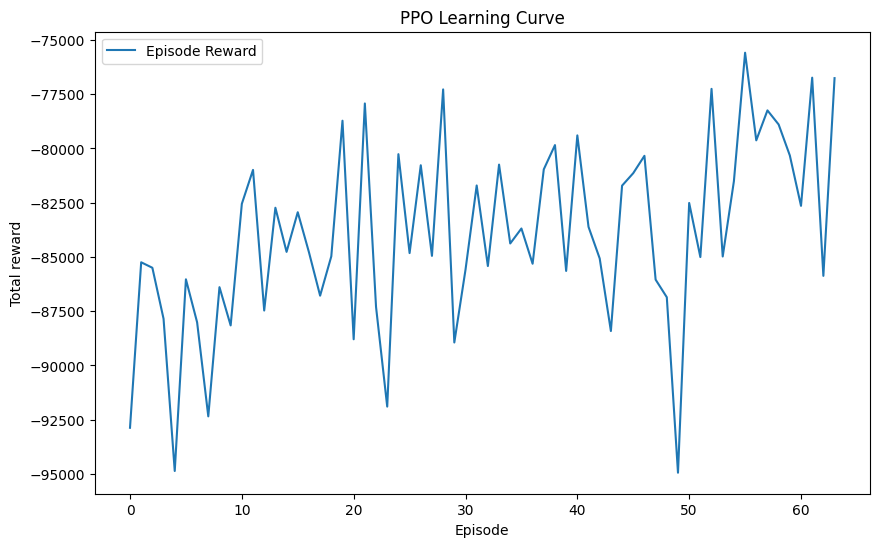

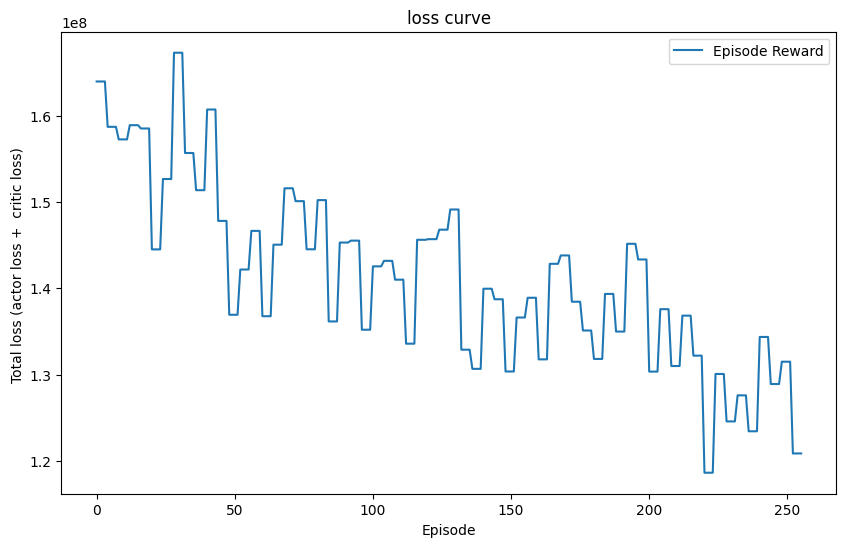

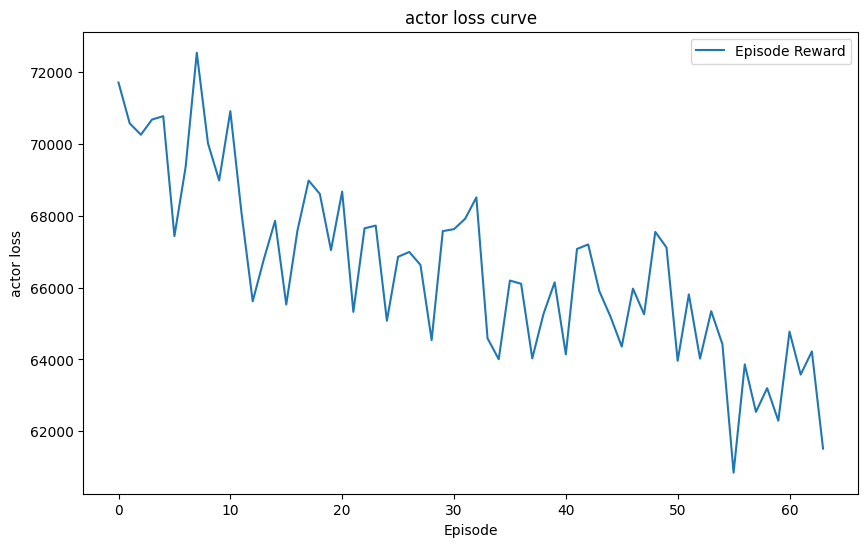

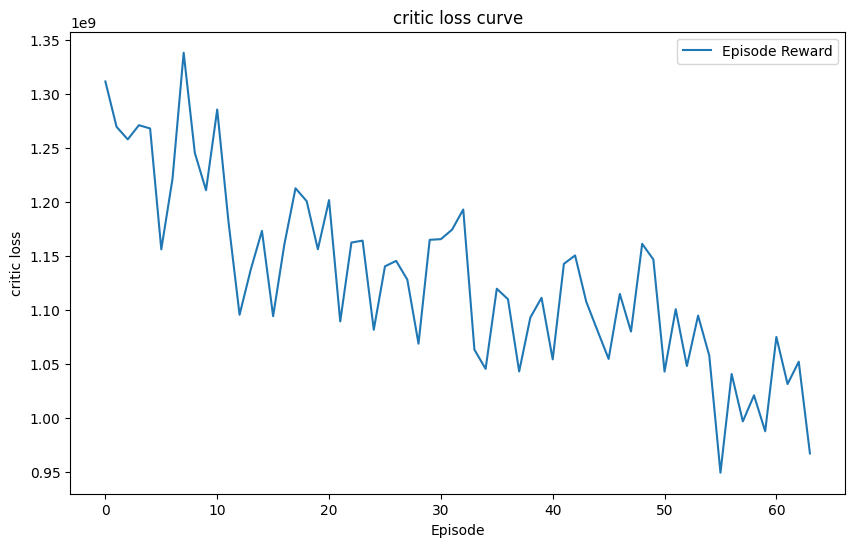

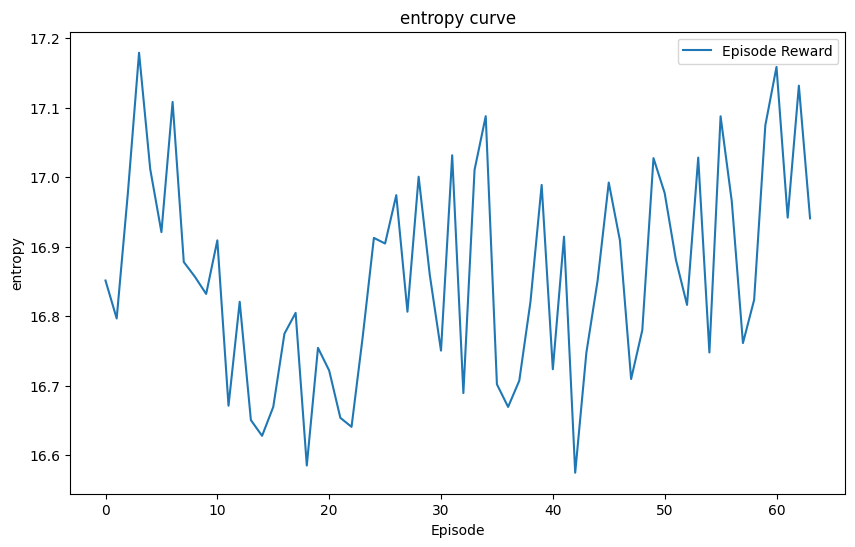

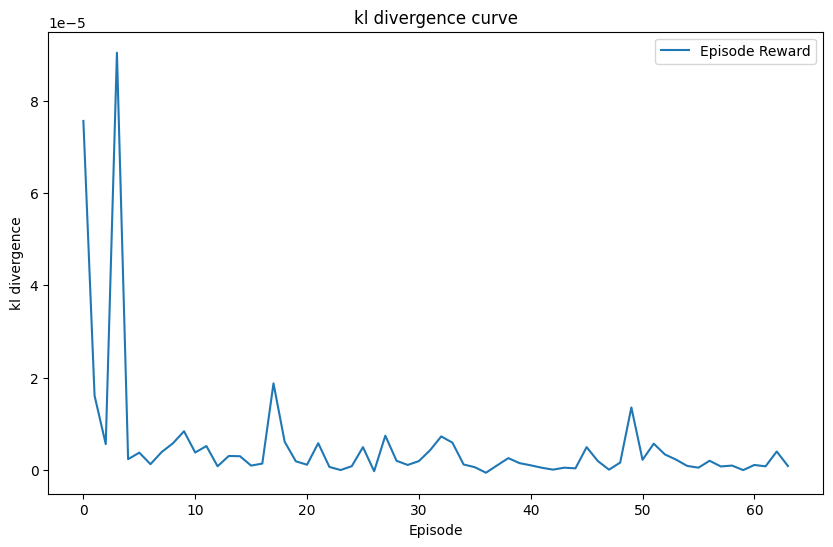

In [11]:
def plot_learning_curve(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()

# エージェントの学習
# (agent.train()の呼び出しなど)

# 学習後のエージェントの評価
#evaluate_agent(agent, env, num_episodes=10)

# 学習曲線のプロット
plot_learning_curve(episode_reward_history, title="PPO Learning Curve", label="Total reward")
plot_learning_curve(agent.loss_history_detail, title="loss curve", label="Total loss (actor loss +  critic loss) ")
plot_learning_curve(agent.actor_loss_history, title="actor loss curve", label="actor loss")
plot_learning_curve(agent.critic_loss_history, title="critic loss curve", label="critic loss")
plot_learning_curve(agent.entropy_history, title="entropy curve", label="entropy")
plot_learning_curve(agent.kl_divergence_history, title="kl divergence curve", label="kl divergence")



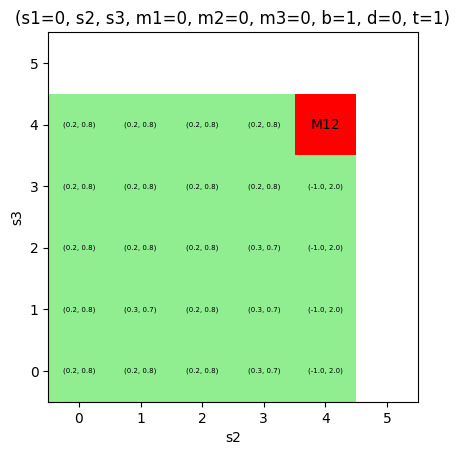

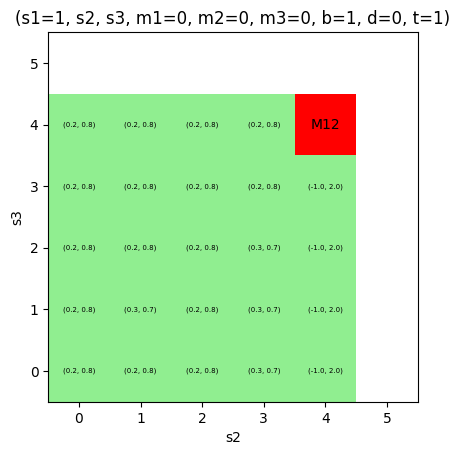

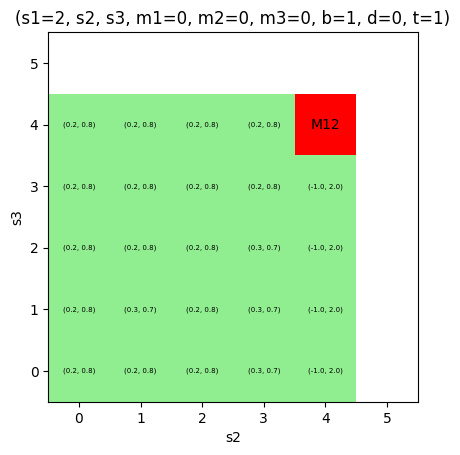

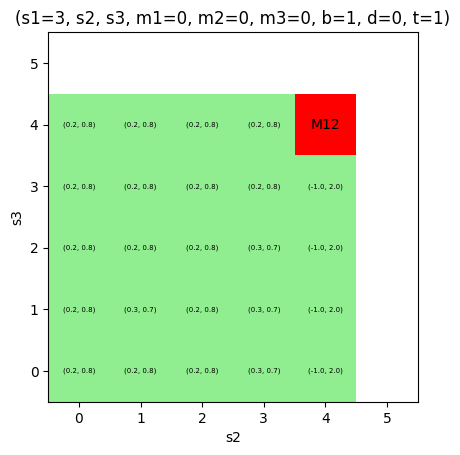

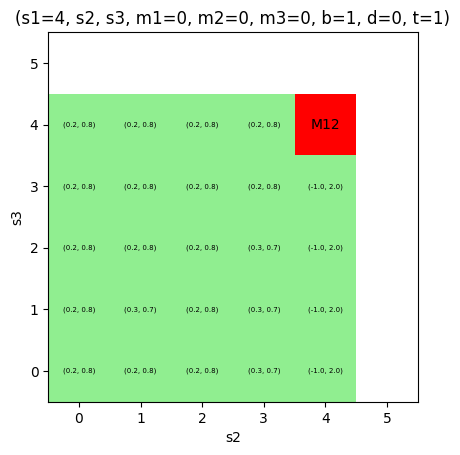

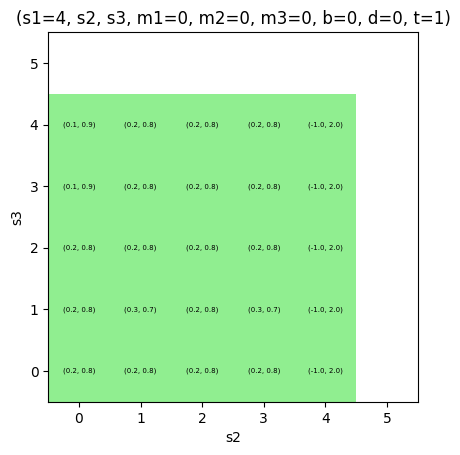

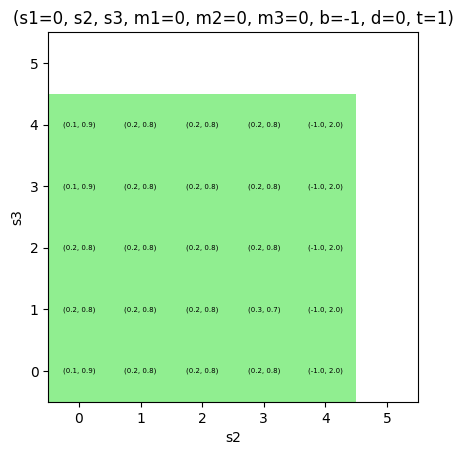

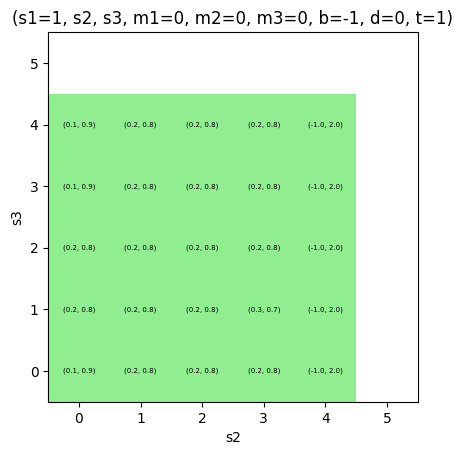

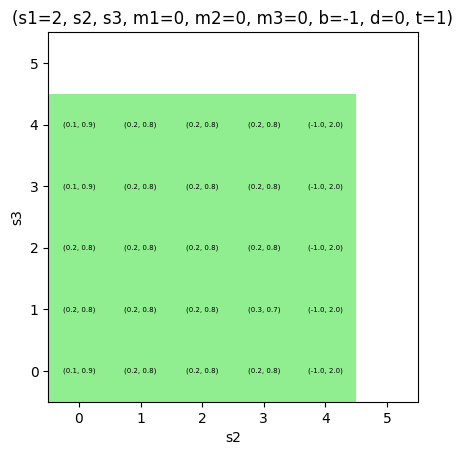

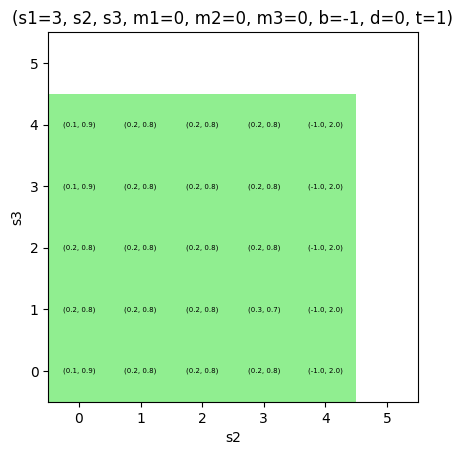

In [12]:




def one_hot_encoding(levels, maintenance_status, n_units=2,n_states=5, MAX_maintenance_time=0):
    level_ohe = []
    mstatus_ohe = []
    for unit_idx in range(n_units):
        l = [0] * n_states
        m = [0] * (MAX_maintenance_time + 1)
        l[levels[unit_idx]] = 1
        m[maintenance_status[unit_idx]] = 1
        level_ohe = level_ohe + l
        mstatus_ohe = mstatus_ohe + m
    return level_ohe, mstatus_ohe


def get_color(action):
    if action < 0:
        print(action)
        return "white"
    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","lightblue"]
    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]
    return cmap[action]

def plot_action(ax, center_x, center_y, act_dsc, act_cnt):
    size = 1
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        1,
        1,
        linewidth = 0,
        facecolor = get_color(act_dsc)
    )
    ax.add_patch(opt_action)
    #print(act_dsc)
    if act_dsc==0:
        ax.text(center_x,center_y,f'M12',ha='center', va='center')
    elif act_dsc==1:
        ax.text(center_x,center_y,f'M1',ha='center', va='center')
    elif act_dsc==2:
        ax.text(center_x,center_y,f'M2',ha='center', va='center')
    else: #稼働継続
        ax.text(center_x, center_y,f'{(round(act_cnt[0],1),round(1-act_cnt[0],1))}',ha='center', va='center',fontsize=5)


def optimal_policy(s1,m1,m2,m3,b,d,t):
    fig, ax = plt.subplots()
    x = 5
    for s2 in range(x):
        for s3 in range(x):
            level_ohe, mstatus_ohe = one_hot_encoding(levels=[s2,s3],maintenance_status=[m2,m3])
            state = level_ohe + mstatus_ohe + list([b,d])
            #print(state)
            act_dsc, act_cnt, log_prob, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            #print(act_dsc,act_cnt)
            plot_action(ax, s2, s3, act_dsc, act_cnt)
    ax.set_xlim(-0.5,x+0.5)
    ax.set_ylim(-0.5,x+0.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s2")
    ax.set_ylabel("s3")
    # グラフを表示
    ax.set_title("(s1="+str(s1)+", s2, s3, m1="+str(m1)+", m2="+str(m2)+", m3="+str(m3)+", b="+str(b)+", d="+str(d)+", t="+str(t)+")")
    plt.show()
optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=1)
optimal_policy(s1=1,m1=0,m2=0,m3=0,b=1,d=0,t=1)
optimal_policy(s1=2,m1=0,m2=0,m3=0,b=1,d=0,t=1)
optimal_policy(s1=3,m1=0,m2=0,m3=0,b=1,d=0,t=1)
optimal_policy(s1=4,m1=0,m2=0,m3=0,b=1,d=0,t=1)
optimal_policy(s1=4,m1=0,m2=0,m3=0,b=0,d=0,t=1)
#optimal_policy(s1=0,m1=1,m2=1,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=0.5)
optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
s1 = 4
s2 = 4
s3 = 4
m1 = 0
m2 = 0
m3 = 0
inventory = 0
#demand = 0
remain_interval = 1
level_ohe, mstatus_ohe = one_hot_encoding(levels=[s1,s2,s3],maintenance_status=[m1,m2,m3])
state = level_ohe + mstatus_ohe + list([inventory,demand,remain_interval])
#act_dsc, act_cnt, log_prob, val = agent.choose_action_max_prob(state)
#act_dsc = act_dsc.item()
#act_dsc